<a href="https://colab.research.google.com/github/montjoile/Meta-learning/blob/master/finetunning_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine Tunning using ResNet50

Experiments using weights from ImageNet

### Mount Google drive

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Libraries

In [0]:
import timeit
import pandas as pd
import numpy as np
import os
from keras.utils import np_utils
from sklearn.utils import shuffle, class_weight
from PIL import Image
from keras.preprocessing import image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import shutil
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import models
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from keras import optimizers
from sklearn.metrics import classification_report, precision_recall_fscore_support
import sklearn.metrics as metrics
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import pandas as pd
from pathlib import Path
import time
import matplotlib.image as mpimg
import math
import seaborn as sn
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import itertools
import seaborn as sns
from keras.applications.resnet50 import ResNet50
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

np.seed = 42

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


###Load data

In [0]:
#read dataset with path of images
df_melanoma = pd.read_csv('/content/drive/My Drive/meta-learning/df_melanoma_colab.csv')
df_melanoma['is_melanoma'] = pd.np.where(df_melanoma['class'].str.contains('melanoma'), 'melanoma', 'not melanoma')
malignant = pd.np.where(df_melanoma['class'].isin({'basal-cell-carcinoma', 'basal_cell_carcinoma', 'squamous_cell_carcinoma'}))
melanoma = pd.np.where(df_melanoma['class'].str.contains('melanoma'))
df_melanoma['label'] = 'benign'
df_melanoma['label-encoded'] = int('1')#


malignant = np.array(malignant).flatten()
melanoma = np.array(melanoma).flatten()
df_melanoma.loc[malignant, 'label'] = 'malignant'
df_melanoma.loc[melanoma, 'label'] = 'melanoma'
df_melanoma.loc[malignant,'label-encoded'] = int('2')#
df_melanoma.loc[melanoma, 'label-encoded'] = int('3')#

#create dataset name codes
dataset_codename = {
    'addi-melanoma':1,
    'derm7pt-melanoma':2,
    'skin-melanoma':3
}

dataset_label_codename = {
    'benign' : int('1'),
    'malignant' : int('2'),
    'melanoma' : int('3')
}

In [0]:
Counter(df_melanoma['label'])

Counter({'benign': 132, 'malignant': 15, 'melanoma': 46})

###Functions definition

In [0]:
#create generators
def create_generators(x_train, x_test, label_col):
  img_height = 256
  img_width = 256
  img_dimension = 3

  #train datagenerator
  datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
  train_generator = datagen.flow_from_dataframe(
          dataframe=x_train,
          x_col='path',
          y_col=label_col,
          subset='training',
          target_size=(256, 256),
          batch_size=32,
          shuffle=True,
          color_mode='rgb',
          class_mode='categorical')
  
  #valid datagenerator
  valid_generator=datagen.flow_from_dataframe(
          dataframe=x_train,
          x_col='path',
          y_col=label_col,
          subset='validation',
          target_size=(256,256),
          batch_size=32,
          shuffle=True,
          color_mode='rgb',
          class_mode='categorical')

  #test datagenerator
  testgen = ImageDataGenerator()
  test_generator = testgen.flow_from_dataframe(
          dataframe=x_test,
          x_col='path',
          y_col=label_col,
          target_size=(256, 256),
          batch_size=32,
          shuffle=False,
          color_mode='rgb',
          class_mode='categorical')
  
  return train_generator, valid_generator, test_generator

In [0]:
# create model
def create_model(num_classes):
  input_tensor = Input(shape=(256, 256, 3))  

  # create the base pre-trained model
  base_model = ResNet50(input_tensor=input_tensor,weights='imagenet',include_top=False)

  #freeze weights
  for layer in base_model.layers:
      layer.trainable=False

  #add dense layer
  x = base_model.output
  x = GlobalAveragePooling2D(data_format='channels_last')(x)
  x = Dense(num_classes, activation='softmax')(x)

  updatedModel = Model(base_model.input, x)

  updatedModel.compile(loss='categorical_crossentropy', 
                  optimizer = keras.optimizers.SGD(
                      lr=0.0001, 
                      momentum=0.9, 
                      nesterov=True),
                  metrics=["accuracy"])

  return updatedModel

In [0]:
# fit model 
def train_model(model, train_generator, test_generator, valid_generator, weight_checkpoint, set_weights):
  
  nb_epochs = 3 
  STEP_SIZE_TRAIN=math.ceil(train_generator.n/nb_epochs)
  STEP_SIZE_VALID=math.ceil(valid_generator.n/nb_epochs)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  
  #set class weights
  if set_weights == True:
    counter_train = Counter(train_generator.classes)
    counter_test = Counter(test_generator.classes)
    max_val = float(max(counter_train.values()))  
    class_weights = {(max_val/counter_train.get(class_id))*(counter_train.get(class_id)/counter_test.get(class_id)) for class_id in range(0,3)}
  else:
    class_weights = None
  
  history = model.fit_generator(generator=train_generator,
                                           steps_per_epoch=STEP_SIZE_TRAIN,
                                           validation_data=valid_generator,
                                           validation_steps=STEP_SIZE_VALID,
                                           callbacks=[es, weight_checkpoint],
                                           class_weight = class_weights,
                                           epochs=nb_epochs)
  best_weights_model = load_model(weight_checkpoint.filepath)
  
  return history.history['acc'], history.history['loss'], history.history['val_acc'], history.history['val_loss'], best_weights_model

In [0]:
#get predictions
def predict_model(model, test_generator):
  STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)
  true_labels = test_generator.classes
  test_generator.reset()

  predictions = model.predict_generator(test_generator, steps=STEP_SIZE_TEST) 
  y_true = true_labels
  y_pred = np.array([np.argmax(x) for x in predictions])
  return y_true, y_pred

In [0]:
#evaluate model
def evaluate_model(model, test_generator):
  STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)

  loss, acc = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST)
  return loss, acc

In [0]:
def plot_confusion_matrix(confusion_matrix, class_names):
  mpl.style.use('seaborn')
  conf_arr = np.array([[88,14,4],[12,85,11],[5,15,91]])
  sum = conf_arr.sum()
  conf_arr = conf_arr * 100.0 / ( 1.0 * sum )

  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

  fig = plt.figure()
  plt.clf()
  ax = fig.add_subplot(111)
  ax.set_aspect(1)

  cmap = sns.cubehelix_palette(rot=-.4)
  res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='d', cmap=cmap)
  res.invert_yaxis()
  plt.yticks([0.5,1.5,2.5], class_names, va='center')
  plt.title('Confusion Matrix')

  #plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight' )
  #plt.close()

In [0]:
#plot classification report
def plot_classification_report(y_true, y_pred, class_names, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = class_names

    rep = np.array(precision_recall_fscore_support(y_true, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    cmap = sns.color_palette("ch:2.8,-.2,dark=.27")
    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                fmt='.2f',
                cmap=cmap,
                ax=ax)

In [0]:
#plot AUC ROC
def auc_roc(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=0)

  #plot ROC
  plt.plot(fpr,tpr)
  plt.show() 

  #plot AUC
  auc = np.trapz(tpr,fpr)
  print('AUC:', auc)

In [0]:
#plot curves of loss and accuracy during training
def plot_acc_loss(acc, val_acc, loss, val_loss):
  f = plt.figure(figsize=(15,5))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  epochs = range(1, len(acc) + 1)

  ax.plot(epochs, acc, 'g', label='Training acc')
  ax.plot(epochs, val_acc, 'b', label='Validation acc')
  ax.set_title('Training and validation accuracy')
  ax.legend()

  ax2.plot(epochs, loss, 'g', label='Training loss')
  ax2.plot(epochs, val_loss, 'b', label='Validation loss')
  ax2.set_title('Training and validation loss')
  ax2.legend()

In [0]:
os.chdir('/content/drive/My Drive/meta-learning/')
acc_finetuning_1 = np.load('acc_finetuning_1.npy')
loss_finetuning_1 = np.load('loss_finetuning_1.npy')
acc_val_finetuning_1 = np.load('val_acc_finetuning_1.npy')
loss_val_finetuning_1 = np.load('val_loss_finetuning_1.npy')

acc_finetuning_2 = np.load('acc_finetuning_2.npy')
loss_finetuning_2 = np.load('loss_finetuning_2.npy')
acc_val_finetuning_2 = np.load('val_acc_finetuning_2.npy')
loss_val_finetuning_2 = np.load('val_loss_finetuning_2.npy')

acc_benchmark = np.load('acc_benchmark1.npy')
loss_benchmark = np.load('loss_benchmark1.npy')
acc_val_benchmark = np.load('val_acc_benchmark1.npy')
loss_val_benchmark = np.load('val_loss_benchmark1.npy')

In [0]:
#jaccard simmilarity index
def jaccard_distance(y_true, y_pred, smooth=100):
  y_true = tf.convert_to_tensor(actual, np.float32)
  y_pred = tf.convert_to_tensor(predicted, np.float32)
  sess = tf.InteractiveSession()  
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  jc = (1 - jac) * smooth
  return sess.run(jc)

###Experiment 1

Cross validation with finetunned ResNet using all the data

In [0]:
def experimento_1(dataset, set_weights, file_name):
    
  total_actual = []
  total_predicted = []
  total_acc = []
  total_loss = []
  total_val_acc = []
  total_val_loss = []
  total_acc_eval = []
  total_loss_eval = []
  total_test_accuracy = []

  kf = StratifiedKFold(n_splits=3, shuffle=True)
  n_splits = kf.get_n_splits(dataset['path'], dataset['label'])


  for i, (train_index, test_index) in enumerate(kf.split(dataset['path'], dataset['label'])):  
    X_train, X_test = dataset.iloc[train_index], dataset.iloc[test_index]
    y_train, y_test = dataset.iloc[train_index]['label'], dataset.iloc[test_index]['label']      

    #set weight checkpoint file
    weight_checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/meta-learning/'+file_name+'.hdf5', 
                                 monitor = 'val_acc',
                                 verbose=1, 
                                 save_best_only=True)

    print('***** Running fold '+ str(i)+' *****')
    print('train size: '+str(X_train.shape[0]))
    print('test size: ' +str(X_test.shape[0]))
    print('train class distribution: '+str(Counter(X_train['label'])))
    print('test class distribution: '+str(Counter(X_test['label'])))

    #create and evaluate model
    model = None
    model = create_model(3)
    train_generator, valid_generator, test_generator = create_generators(X_train, X_test, 'label')


    acc, loss, val_acc, val_loss, best_model = train_model(model, train_generator, test_generator, valid_generator, weight_checkpoint, set_weights)
    actual, predicted = predict_model(best_model, test_generator)
    loss_eval, acc_eval = evaluate_model(best_model, test_generator)


    #append validation accuracy and loss for average calculation later on
    total_acc.append(acc)
    total_loss.append(loss)
    total_val_acc.append(val_acc)
    total_val_loss.append(val_loss)

    print('actual size:'+str(len(actual)))
    print('predicted size:'+str(len(predicted)))

    #append accuracy from the predictions on the test data
    total_test_accuracy.append(accuracy_score(actual, predicted))

    #append all of the actual and predicted classes for your final evaluation
    total_actual.append(actual)
    total_predicted.append(predicted)

    total_loss_eval.append(loss_eval)
    total_acc_eval.append(acc_eval)


  #modify to plot
  y_true = []
  y_pred = []
  v_acc = []
  v_loss = []
  v_val_acc = []
  v_val_loss = []
  v_acc_eval = []
  v_loss_eval = []

  for i in range(0, n_splits):
    for j in range(0, len(total_actual[i])):
      y_true.append(total_actual[i][j])

  for i in range(0, n_splits):
    for j in range(0, len(total_predicted[i])):
      y_pred.append(total_predicted[i][j])

  for i in range(0, n_splits):
    for j in range(0, n_splits):
      v_acc.append(total_acc[i][j])
      v_loss.append(total_loss[i][j])
      v_val_acc.append(total_val_acc[i][j])
      v_val_loss.append(total_val_loss[i][j])
      
  for i in range(0, n_splits):
    v_acc_eval.append(total_acc_eval[i])
    v_loss_eval.append(total_loss_eval[i])
      
      
  #save results
  os.chdir('/content/drive/My Drive/meta-learning/')
  np.save('acc_'+file_name, v_acc)
  np.save('loss_'+file_name, v_loss)
  np.save('val_acc_'+file_name, v_val_acc)
  np.save('val_loss_'+file_name, v_val_loss)
  np.save('acc_eval_'+file_name, total_acc_eval)
  np.save('loss_eval_'+file_name, total_loss_eval)
  np.save('actual_'+file_name, y_true)
  np.save('predicted_'+file_name, y_pred)
  np.save('total_test_accuracy_'+file_name, total_test_accuracy)
    
    
  return v_acc, v_loss, v_val_acc, v_val_loss, total_acc_eval, total_loss_eval, y_true, y_pred, total_test_accuracy, best_model

In [0]:
#no weighted class
start = time.time()
acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, total_test_accuracy, model = experimento_1(df_melanoma, False, 'finetuning_1')
end = time.time()
print(end-start)

***** Running fold 0 *****
train size: 128
test size: 65
train class distribution: Counter({'benign': 88, 'melanoma': 30, 'malignant': 10})
test class distribution: Counter({'benign': 44, 'melanoma': 16, 'malignant': 5})


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 103 validated image filenames belonging to 3 classes.
Found 25 validated image filenames belonging to 3 classes.
Found 65 validated image filenames belonging to 3 classes.
Epoch 1/3
35/35 [==============================] - 24s 676ms/step - loss: 1.0880 - acc: 0.5012 - val_loss: 1.3510 - val_acc: 0.2800

Epoch 00001: val_acc improved from -inf to 0.28000, saving model to /content/drive/My Drive/meta-learning/finetuning_2.hdf5
Epoch 2/3
35/35 [==============================] - 8s 228ms/step - loss: 0.8157 - acc: 0.6850 - val_loss: 1.3182 - val_acc: 0.2800

Epoch 00002: val_acc did not improve from 0.28000
Epoch 3/3
35/35 [==============================] - 9s 255ms/step - loss: 0.7477 - acc: 0.7087 - val_loss: 1.2197 - val_acc: 0.2800

Epoch 00003: val_acc did not improve from 0.28000
actual size:65
predicted size:65
***** Running fold 1 *****
train size: 129
test size: 64
train class distribution: Counter({'benign': 88, 'melanoma': 31, 'malignant': 10})
test class distribution: Cou

In [0]:
#no weighted class
print(jaccard_distance(actual, predicted))
print(total_test_accuracy)
print(f1_score(actual, predicted, average='weighted'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


43.037975
[0.47692307692307695, 0.546875, 0.6875]
0.5443692963165002


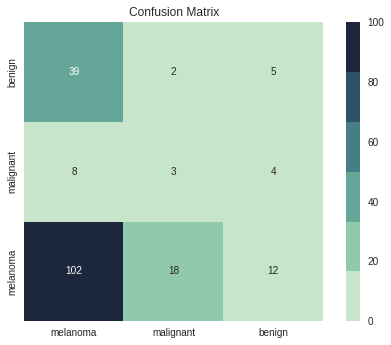

In [0]:
plot_confusion_matrix(confusion_matrix(actual, predicted), {'benign', 'malignant', 'melanoma'})

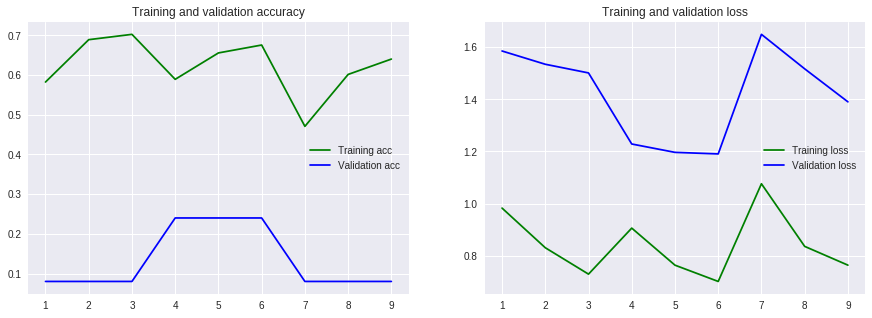

In [0]:
plot_acc_loss(acc, val_acc, loss, val_loss)

In [0]:
#weighted class
start = time.time()
acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, total_test_accuracy, model = experimento_1(df_melanoma, True, 'finetuning_2')
end = time.time()
print(end-start)

***** Running fold 0 *****
train size: 128
test size: 65
train class distribution: Counter({'benign': 88, 'melanoma': 30, 'malignant': 10})
test class distribution: Counter({'benign': 44, 'melanoma': 16, 'malignant': 5})


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 103 validated image filenames belonging to 3 classes.
Found 25 validated image filenames belonging to 3 classes.
Found 65 validated image filenames belonging to 3 classes.
Epoch 1/3
35/35 [==============================] - 21s 595ms/step - loss: 0.8786 - acc: 0.6541 - val_loss: 1.0046 - val_acc: 0.6400

Epoch 00001: val_acc improved from -inf to 0.64000, saving model to /content/drive/My Drive/meta-learning/finetuning_1.hdf5
Epoch 2/3
35/35 [==============================] - 7s 211ms/step - loss: 0.7258 - acc: 0.7068 - val_loss: 0.9971 - val_acc: 0.6400

Epoch 00002: val_acc did not improve from 0.64000
Epoch 3/3
35/35 [==============================] - 9s 248ms/step - loss: 0.6687 - acc: 0.7306 - val_loss: 1.0172 - val_acc: 0.6400

Epoch 00003: val_acc did not improve from 0.64000
actual size:65
predicted size:65
***** Running fold 1 *****
train size: 129
test size: 64
train class distribution: Counter({'benign': 88, 'melanoma': 31, 'malignant': 10})
test class distribution: Cou

In [0]:
#weighted class
print(jaccard_distance(actual, predicted))
print(total_test_accuracy)
print(f1_score(actual, predicted, average='weighted'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


47.22222
[0.5384615384615384, 0.5625, 0.59375]
0.5339194361995352


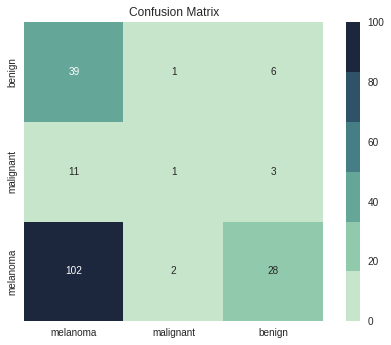

In [0]:
plot_confusion_matrix(confusion_matrix(actual, predicted), {'benign', 'malignant', 'melanoma'})

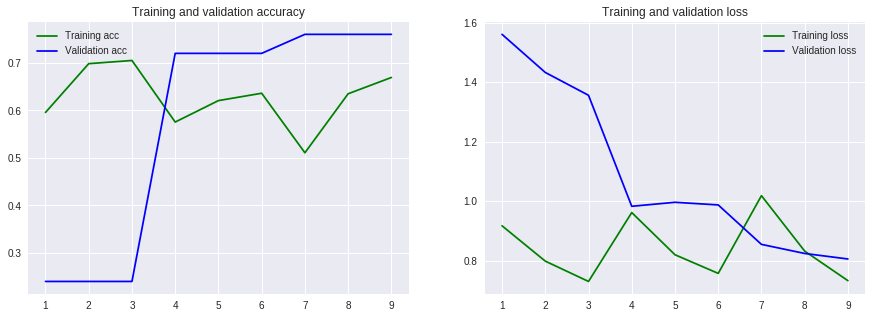

In [0]:
plot_acc_loss(acc, val_acc, loss, val_loss)